In [87]:
import collections
import numpy as np
import pandas as pd
import re

from mlxtend.plotting import plot_confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [88]:
data = pd.read_csv('../data/twitter_sentiment_analysis_data_raw.csv', encoding='latin-1', names=['label', 'id', 'data', 'query', 'author', 'tweet'])

In [89]:
data.loc[data['label']==4, 'label'] = 1
data.label.value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [90]:
data.head()

,label,id,data,query,author,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [91]:
def words_stemming(words_list):    
    ps = PorterStemmer()
    stem_words = [ps.stem(word) for word in words_list]
    return stem_words

In [92]:
def reduce_stop_words(words_list):
    text = ' '.join(words_list)
    filtered_sentence = remove_stopwords(text)
    return filtered_sentence.split()

In [93]:
def adjust_tweet(sentence):    
    re_punctuations = r""",|'|\.|!|\?|&|"|:|[|]|;|quot|\\/|\\(|\\)|http\S+|www\S+|@\S+|.com\S+|-|_|=|\+"""        
    words_list = re.sub(re_punctuations, "", sentence.lower()).split()    
    
    words_list = [word for word in words_list if len(word) > 1]        
    
    words_list = words_stemming(words_list)
    
    words_list = reduce_stop_words(words_list)
    
    return ' '.join(words_list)

In [94]:
def txt_to_list(file_name):
    my_file = open(file_name, "r", encoding="utf8")
    content_list = [line.rstrip('\n') for line in my_file.readlines()]
    return content_list

def build_vocabularies(data, label_col, sentence_col):
    pos_vocabulary = [
        word
        for tweet in data.loc[data[label_col]==1, sentence_col].values.tolist() 
        for word in tweet.split() 
    ]
    
    neg_vocabulary = [
        word
        for tweet in data.loc[data[label_col]==0, sentence_col].values.tolist() 
        for word in tweet.split() 
    ]

    return pos_vocabulary, neg_vocabulary    

In [95]:
def build_vocabulary(pos_freq=pos_freq, neg_freq=neg_freq):
    df_pos = pd.DataFrame([(k, v) for k, v in pos_freq.items()], columns=['word', 'pos_count'])
    df_neg = pd.DataFrame([(k, v) for k, v in neg_freq.items()], columns=['word', 'neg_count'])
    df_vocabulary = pd.merge(df_pos, df_neg, on='word', how='outer').fillna(0)
    
    df_vocabulary['p_pos'] = (df_vocabulary['pos_count'] + 1) / (df_pos.shape[0] + df_vocabulary.shape[0])
    df_vocabulary['p_neg'] = (df_vocabulary['neg_count'] + 1) / (df_pos.shape[0] + df_vocabulary.shape[0])
    
    df_vocabulary['ratio'] = df_vocabulary['p_pos'] / df_vocabulary['p_neg']
    df_vocabulary['lambda'] = np.log2(df_vocabulary['ratio'])
    
    return df_vocabulary

In [137]:
def calculate_scores(sentence, log_prior=0, df_vocabulary=df_vocabulary):
    lambdas_dict = {k: v for k, v in df_vocabulary[['word', 'lambda']].to_numpy().tolist()}
    score = 0
    
    for word in sentence.split():
        score += lambdas_dict.get(word, 0)
    return score + log_prior

# Sampled data

In [111]:
df = data.groupby('label').head(1250).reset_index(drop=True)

In [112]:
train, test = train_test_split(df, test_size=0.7, random_state=42)

In [113]:
train['adjusted_tweet'] = train['tweet'].apply(adjust_tweet)
test['adjusted_tweet'] = test['tweet'].apply(adjust_tweet)

pos_vocabulary, neg_vocabulary = build_vocabularies(train, 'label', 'adjusted_tweet')
neg_freq = collections.Counter(x for x in neg_vocabulary)
pos_freq = collections.Counter(x for x in pos_vocabulary)

In [114]:
train.head()

,label,id,data,query,author,tweet,adjusted_tweet
132,0,1467842107,Mon Apr 06 22:28:02 PDT 2009,NO_QUERY,wiccabuffy,"@Knights_ No, no notice. They told me I'd be working tomorrow, and then I called the agency to follow up and they said it was over.",notic told id work tomorrow agenc follow said wa
80,0,1467834053,Mon Apr 06 22:25:52 PDT 2009,NO_QUERY,thelazyboy,sleep soon... i just hate saying bye and see you tomorrow for the night.,sleep soon hate bye tomorrow night
1586,1,1467881695,Mon Apr 06 22:38:24 PDT 2009,NO_QUERY,JonLanderos,"Ahh, the tedium of fixing broken file links in Inventor. Good times.",ahh tedium fix broken file link inventor good time
2157,1,1467987805,Mon Apr 06 23:08:11 PDT 2009,NO_QUERY,Tarale,"Had a great lunch with one of my &quot;mums&quot; today, @christineirmler It's her birthday tomorrow too so I got her a little something",great lunch mum today birthday tomorrow got littl someth
758,0,1467999499,Mon Apr 06 23:11:30 PDT 2009,NO_QUERY,jj_1983,Back at work @ John Muir Dr http://loopt.us/KoqAbg,work john muir dr


In [115]:
df_vocabulary = build_vocabulary()
df_vocabulary.loc[df_vocabulary['pos_count'] == 0].head(5)

,word,pos_count,neg_count,p_pos,p_neg,ratio,lambda
1325,agenc,0.0,2.0,0.000285,0.000856,0.333333,-1.584963
1326,bye,0.0,1.0,0.000285,0.000570,0.500000,-1.000000
1327,john,0.0,2.0,0.000285,0.000856,0.333333,-1.584963
1328,muir,0.0,1.0,0.000285,0.000570,0.500000,-1.000000
1329,suck,0.0,5.0,0.000285,0.001711,0.166667,-2.584963


In [116]:
train.head()

,label,id,data,query,author,tweet,adjusted_tweet
132,0,1467842107,Mon Apr 06 22:28:02 PDT 2009,NO_QUERY,wiccabuffy,"@Knights_ No, no notice. They told me I'd be working tomorrow, and then I called the agency to follow up and they said it was over.",notic told id work tomorrow agenc follow said wa
80,0,1467834053,Mon Apr 06 22:25:52 PDT 2009,NO_QUERY,thelazyboy,sleep soon... i just hate saying bye and see you tomorrow for the night.,sleep soon hate bye tomorrow night
1586,1,1467881695,Mon Apr 06 22:38:24 PDT 2009,NO_QUERY,JonLanderos,"Ahh, the tedium of fixing broken file links in Inventor. Good times.",ahh tedium fix broken file link inventor good time
2157,1,1467987805,Mon Apr 06 23:08:11 PDT 2009,NO_QUERY,Tarale,"Had a great lunch with one of my &quot;mums&quot; today, @christineirmler It's her birthday tomorrow too so I got her a little something",great lunch mum today birthday tomorrow got littl someth
758,0,1467999499,Mon Apr 06 23:11:30 PDT 2009,NO_QUERY,jj_1983,Back at work @ John Muir Dr http://loopt.us/KoqAbg,work john muir dr


In [138]:
log_prior = np.log(train.loc[train['label'] == 1].shape[0] / train.loc[train['label'] == 0].shape[0])
test['score'] = test['adjusted_tweet'].apply(calculate_scores, (log_prior))
test['pred'] = (test['score'] > 0).astype(int)

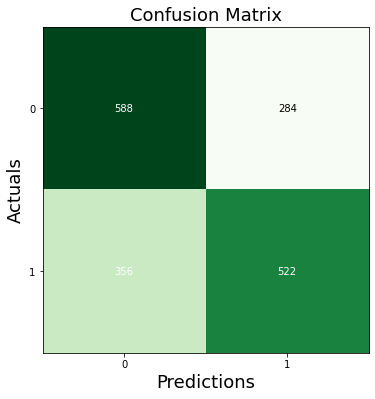

In [139]:
conf_mat = confusion_matrix(test['label'], test['pred'])
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [140]:
logreg=accuracy_score(test['label'], test['pred'])
logreg

0.6342857142857142

In [141]:
roc_auc_score(test['label'], test['pred'])

0.6344224781091304

In [142]:
print(metrics.classification_report(test['label'], test['pred']))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65       872
           1       0.65      0.59      0.62       878

    accuracy                           0.63      1750
   macro avg       0.64      0.63      0.63      1750
weighted avg       0.64      0.63      0.63      1750



# Using all data

In [143]:
df = data
df.label.value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [144]:
train, test = train_test_split(df, test_size=0.7, random_state=42)

train['adjusted_tweet'] = train['tweet'].apply(adjust_tweet)
test['adjusted_tweet'] = test['tweet'].apply(adjust_tweet)

pos_vocabulary, neg_vocabulary = build_vocabularies(train, 'label', 'adjusted_tweet')
neg_freq = collections.Counter(x for x in neg_vocabulary)
pos_freq = collections.Counter(x for x in pos_vocabulary)

In [145]:
log_prior = np.log(train.loc[train['label'] == 1].shape[0] / train.loc[train['label'] == 0].shape[0])
test['score'] = test['adjusted_tweet'].apply(calculate_scores, (log_prior))
test['pred'] = (test['score'] > 0).astype(int)

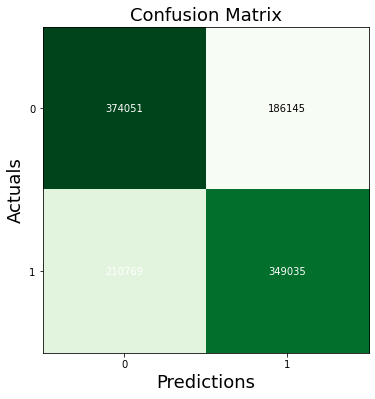

In [146]:
conf_mat = confusion_matrix(test['label'], test['pred'])
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [147]:
logreg=accuracy_score(test['label'], test['pred'])
logreg

0.6456125

In [148]:
roc_auc_score(test['label'], test['pred'])

0.6456047615865833

In [149]:
print(metrics.classification_report(test['label'], test['pred']))

              precision    recall  f1-score   support

           0       0.64      0.67      0.65    560196
           1       0.65      0.62      0.64    559804

    accuracy                           0.65   1120000
   macro avg       0.65      0.65      0.65   1120000
weighted avg       0.65      0.65      0.65   1120000

